In [1]:
import os
benign_path = 'D:\\project\\Dataset_BUSI_with_GT\\benign'
malign_path = 'D:\\project\\Dataset_BUSI_with_GT\\malignant'
normal_path = 'D:\\project\\Dataset_BUSI_with_GT\\normal'


def count_files(directory):
    return len([f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))])


benign_count = count_files(benign_path)
malign_count = count_files(malign_path)
normal_count = count_files(normal_path)


print(f'Benign: {benign_count} images')
print(f'Malignant: {malign_count} images')
print(f'Normal: {normal_count} images')

Benign: 891 images
Malignant: 421 images
Normal: 266 images


In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from keras import Sequential, Model
from keras.layers import Input, Conv2D, Conv2DTranspose, concatenate, BatchNormalization, Activation, MaxPooling2D, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam



clients_data = {i: {'images': [], 'masks': []} for i in range(5)}

In [3]:
def load_image_mask_clients(image_path=None, shape=128):
    file_names = os.listdir(image_path)
    image_names, mask_names = [], []
    partial_names = list(set([fn.split(')')[0] for fn in file_names]))
    
    for name in partial_names:
        image_names.append(name + ').png')
        mask_names.append(name + ')_mask.png')
    
    for i, image_name in enumerate(image_names):
        image = plt.imread(os.path.join(image_path, image_name))
        mask = plt.imread(os.path.join(image_path, mask_names[i]))
        image = cv2.resize(image, (shape, shape))
        mask = cv2.resize(mask, (shape, shape))

        client_idx = i % 5
        clients_data[client_idx]['images'].append(image)
        clients_data[client_idx]['masks'].append(mask)

base_dir = "D:\\project\\Dataset_BUSI_with_GT"
categories = ['benign', 'malignant']
for category in categories:
    load_image_mask_clients(image_path=os.path.join(base_dir, category))

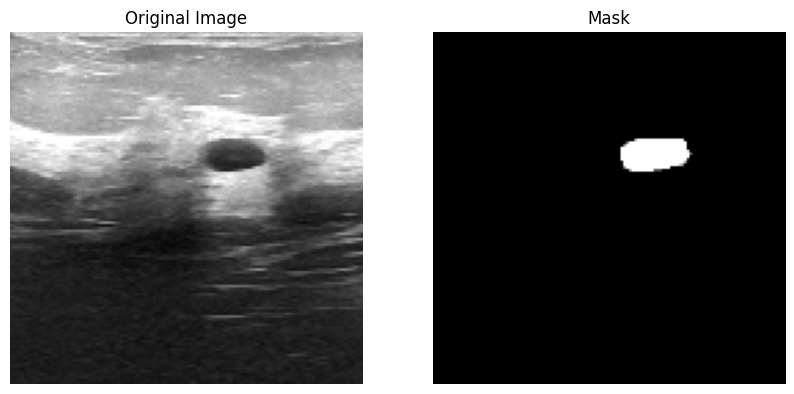

In [4]:
import matplotlib.pyplot as plt

def display_image_mask_pair(client_id=0, index=0):
    image = clients_data[client_id]['images'][index]
    mask = clients_data[client_id]['masks'][index]
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image)
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(mask, cmap='gray')
    ax[1].set_title("Mask")
    ax[1].axis('off')

    plt.show()

display_image_mask_pair(client_id=0, index=0)

In [5]:
def modelArchitecture(input_layer, dropoutRate=0.2):
    conv1 = Conv2D(64, 3, padding='same')(input_layer)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    conv1 = Dropout(dropoutRate)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    conv2 = Dropout(dropoutRate)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    conv3 = Dropout(dropoutRate)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Dropout(dropoutRate)(conv4)

    upconv1 = Conv2DTranspose(256, 3, strides=(2, 2), padding='same')(conv4)
    concat1 = concatenate([upconv1, conv3])
    conv5 = Conv2D(256, 3, padding='same')(concat1)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    upconv2 = Conv2DTranspose(128, 3, strides=(2, 2), padding='same')(conv5)
    concat2 = concatenate([upconv2, conv2])
    conv6 = Conv2D(128, 3, padding='same')(concat2)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)

    upconv3 = Conv2DTranspose(64, 3, strides=(2, 2), padding='same')(conv6)
    concat3 = concatenate([upconv3, conv1])
    conv7 = Conv2D(64, 3, padding='same')(concat3)
    conv7 = BatchNormalization()(conv7)
    conv7 = Activation('relu')(conv7)

    output_layer = Conv2D(1, 1, padding='same', activation='sigmoid')(conv7)
    
    print("Model architecture created.")
    return Model(inputs=input_layer, outputs=output_layer)


In [6]:
def aggregate_client_models_fedacc(models, client_metrics):
    accuracies = client_metrics['accuracies']
    losses = client_metrics['losses']
    confidence_intervals = client_metrics['conf_intervals']

    alpha, beta, gamma = 0.6, 0.2, 0.2
    total_quality = 0
    normalized_weights = []
    
    for i in range(len(models)):
        quality = (alpha * accuracies[i]) + (beta * (1 - losses[i])) + (gamma * confidence_intervals[i])
        total_quality += quality
        normalized_weights.append(quality)
    
    normalized_weights = [w / total_quality for w in normalized_weights]

    aggregated_weights = models[0].get_weights()
    for i in range(1, len(models)):
        for j in range(len(aggregated_weights)):
            aggregated_weights[j] += normalized_weights[i] * models[i].get_weights()[j]
    
    base_model = models[0]
    base_model.set_weights(aggregated_weights)
    
    print("Aggregation complete. Model updated with aggregated weights.")
    return base_model


In [7]:
clients_models = [modelArchitecture(Input((128, 128, 3)), dropoutRate=0.2) for _ in range(5)]
for i, model in enumerate(clients_models):
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
    print(f"Client model {i+1} compiled.")

client_histories, client_accuracies, client_losses, client_conf_intervals = [], [], [], []  
for i, client_data in clients_data.items():
    print(f"Client {i+1}: {len(client_data['images'])} images, {len(client_data['masks'])} masks")


    if len(client_data['images']) < 5:
        print(f"Skipping training for client {i+1} due to insufficient data.")
        continue

    print(f"Training client model {i+1}...")
    history = clients_models[i].fit(
        np.array(client_data['images']),
        np.array(client_data['masks']),
        epochs=10,
        validation_split=0.25,
        callbacks=[EarlyStopping(monitor='val_loss',patience=5, restore_best_weights=True)]
    )
    client_histories.append(history)
    client_accuracies.append(max(history.history['val_accuracy']))
    client_losses.append(min(history.history['val_loss']))
    client_conf_intervals.append(np.std(history.history['val_accuracy']))
    print(f"Client model {i+1} training complete.")


client_metrics = {
    'accuracies': client_accuracies,
    'losses': client_losses,
    'conf_intervals': client_conf_intervals
}
print("Client metrics collected.")


Model architecture created.
Model architecture created.
Model architecture created.
Model architecture created.
Model architecture created.
Client model 1 compiled.
Client model 2 compiled.
Client model 3 compiled.
Client model 4 compiled.
Client model 5 compiled.
Client 1: 130 images, 130 masks
Training client model 1...
Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 30s 5s/step - accuracy: 0.5826 - loss: 0.7187 - val_accuracy: 0.3575 - val_loss: 0.6957
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.6230 - loss: 0.6533 - val_accuracy: 0.6738 - val_loss: 0.6909
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7021 - loss: 0.6042 - val_accuracy: 0.7507 - val_loss: 0.6871
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7531 - loss: 0.5731 - val_accuracy: 0.7841 - val_loss: 0.6794
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.7975 - loss: 0.5373 - val_accuracy: 0.7858 - val_loss: 0.6737
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accura

Starting aggregation of client models...
Aggregation complete. Model updated with aggregated weights.
Training aggregated model...
Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 9s/step - accuracy: 0.8816 - loss: 0.3670 - val_accuracy: 0.8970 - val_loss: 0.4409
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 138s 9s/step - accuracy: 0.9200 - loss: 0.2560 - val_accuracy: 0.8970 - val_loss: 0.3715
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 136s 9s/step - accuracy: 0.9247 - loss: 0.2259 - val_accuracy: 0.8970 - val_loss: 0.3400
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.9226 - loss: 0.2203 - val_accuracy: 0.8970 - val_loss: 0.3245
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 118s 7s/step - accuracy: 0.9291 - loss: 0.2036 - val_accuracy: 0.8970 - val_loss: 0.3232
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.9290 - loss: 0.1993 - val_accuracy: 0.8970 - val_loss: 0.3270
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 117s 7s/step - accuracy: 0.9301 - loss: 0.1939 - val_accuracy: 0.8970

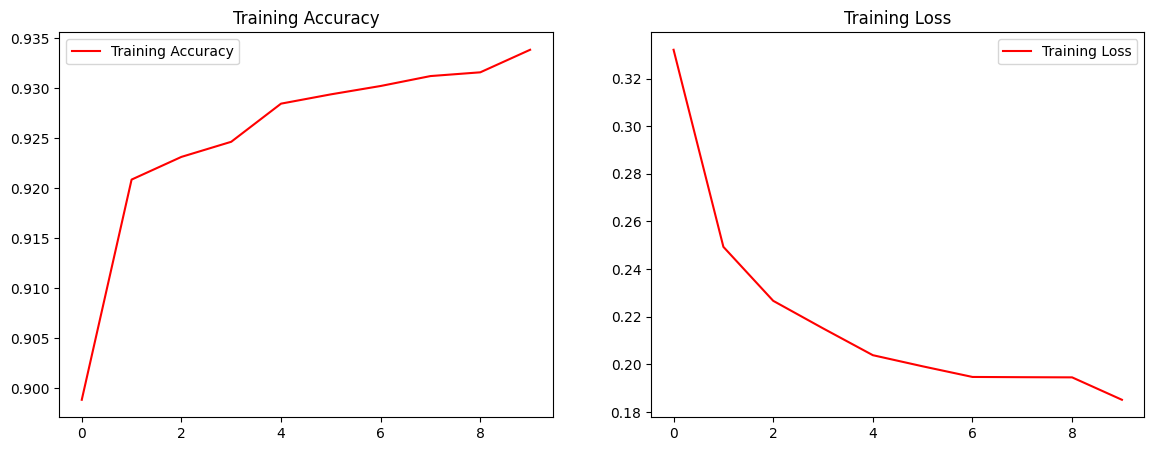

In [8]:
print("Starting aggregation of client models...")
aggregated_model = aggregate_client_models_fedacc(clients_models, client_metrics)

print("Training aggregated model...")
history_aggregated = aggregated_model.fit(
    np.array([img for client in clients_data.values() for img in client['images']]),
    np.array([mask for client in clients_data.values() for mask in client['masks']]),
    epochs=10,
    validation_split=0.25,
    callbacks=[EarlyStopping(patience=5, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1)]
)
print("Aggregated model training complete.")

def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.title('Training Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.title('Training Loss')
    plt.legend()

    plt.show()

print("Plotting training history...")
plot_training_history(history_aggregated)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


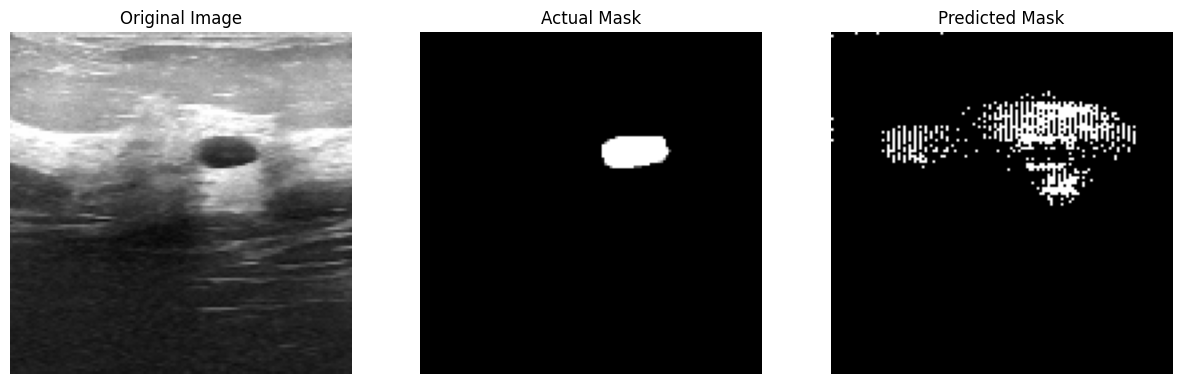

In [11]:
def segment_and_visualize(model , images , masks):
   sample_index=0 
   original_image=images[sample_index]
   actual_mask=masks[sample_index]


   original_image_resized=cv2.resize(original_image,(128 ,128))
   original_image_input=np.expand_dims(original_image_resized , axis=0) 


   predicted_mask=model.predict(original_image_input)[0] 

   
   predicted_mask_binarized=(predicted_mask > 0.18).astype(np.uint8)

   plt.figure(figsize=(15 ,5))


   plt.subplot(1 ,3 ,1)
   plt.imshow(cv2.cvtColor(original_image_resized , cv2.COLOR_BGR2RGB))
   plt.title('Original Image')
   plt.axis('off')

  
   plt.subplot(1 ,3 ,2)
   plt.imshow(actual_mask,cmap='gray')
   plt.title('Actual Mask')
   plt.axis('off')


   plt.subplot(1 ,3 ,3)
   plt.imshow(predicted_mask_binarized,cmap='gray')
   plt.title('Predicted Mask')
   plt.axis('off')

   plt.show()


all_images=[img for client in clients_data.values() for img in client['images']]
all_masks=[mask for client in clients_data.values() for mask in client['masks']]


segment_and_visualize(aggregated_model , all_images , all_masks)